# Session 5

# Introduction to Bayesian Inference

"I can live with doubt and uncertainty... I have approximate answers and possible beliefs and different degrees of certainty about different things, and I'm not absolutely sure of anything..."

Richard Feynman

In [1]:
#Load the libraries.

%matplotlib inline
import warnings
import numpy as np
import pandas as pd
from numpy import random
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import Quandl
import statsmodels as sm
import statsmodels.formula.api as smf
import statsmodels.api as sma
import patsy
from statsmodels.graphics.api import abline_plot
import numpy.linalg as linalg
import pymc3 as pm
from mpl_toolkits.mplot3d import Axes3D
warnings.simplefilter('ignore')
sns.set(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1, rc=None)

## Housekeeping

In this lecture I will be pivoting between R and Python to show the basic concepts of Bayesian inference.  Toward the end of the lecture, I will need a volunteer with a MacBook to plug in to the screen to run the Bayesian linear model for CAPM.  This person needs to have already installed the pymc3 library for Python.

## Overview

In this lecture, we will discuss the distinction between the frequentist approach to statistical learning and the Bayesian approach.  You should have already watched the videos on:

1. Conditional Probability
2. An example of Bayes Theorem
3. The "Monte Hall" Problem (which is another example of conditional probability)

Bayes theorem is typically taught in applied data science courses, such as this one, using the example in the video.  It is presented as a simple exercise at calculating "inverse probability".  The topic of Bayesian analysis is then oddly dropped, and students are asked to refocus on the frequentist approach (using the tools we already discussed and those we will discuss).  But having watched the video (and perhaps having solved the problem presented in the video), you have already conducted Bayesian analysis.    

This purpose of this lecture is to introduce you to the methods by which we can apply Bayes theorem in a meaningful way to real-world data.  To do so, we will address the ingredients of Bayesian inference using a variety of examples.

1. Probabilistically assess whether a coin is balanced (or fair) by combining our prior beliefs with experimental data.  (If you understand this simple example, then you understand the core of the Bayesian approach to inference.)  
2. Use two popular Markov Chain Monte Carlo (MCMC) simulation methods, the Gibbs and the Metropolis-Hastings algorithms.  (The focus here will what they do rather than on how they work.  In particular, you will see that these MCMC algorithms are able to simulate probabilty distributions extraordinarily well.) 
3. Simulate the posterior probabilty distributions of $\alpha$ and $\beta$ from the CAPM.  (Here you will see the strength of the Bayesian approach to inference, in particular the ease of hypothesis testing from a Bayesian perspective.)  

At the end of lecture, my goal is for you to:

1. Understand the Bayesian approach to inference.
2. Understand the use of MCMC algoritms as simulation tools of the posterior probability distribution (given data and prior beliefs).
3. To see how simple hypothesis testing really is (and why it is so difficult to explain from a frequentist perspective).

## The Buzz

"Now Bayesian statistics are rippling through everything from physics to cancer research, ecology to psychology. Enthusiasts say they are allowing scientists to solve problems that would have been considered impossible just 20 years ago. And lately, they have been thrust into an intense debate over the reliability of research results."  

"The essence of the frequentist technique is to apply probability to data. If you suspect your friend has a weighted [unfair] coin, for example, and you observe that it came up heads nine times out of 10, a frequentist would calculate the probability of getting such a result with an unweighted [fair] coin. The answer (about 1 percent) is not a direct measure of the probability that the coin is weighted [unfair]; it’s a measure of how improbable the nine-in-10 result is — a piece of information that can be useful in investigating your suspicion."

"By contrast, Bayesian calculations go straight for the probability of the hypothesis, factoring in not just the data from the coin-toss experiment but any other relevant information — including whether you have previously seen your friend use a weighted [unfair] coin."

The New York Times, Sept. 29, 2014.

http://www.nytimes.com/2014/09/30/science/the-odds-continually-updated.html

## Why?

1. General increase in the demand for data science.
2. Clinical trials.
3. Survey research.
4. Data-driven policy evaluation in both the public and private sectors.
5. Computational speed and the advance of open source statistical learning environments.
6. Limitations of the frequentist approach to inference that are now hindering the advance of data science in decision- and policy-making.  In particular, the implicit reliance on non-existent repeated samples and fixed parameter values that underlies the frequentist approach to data science. 

## A Brief History

Mathematicians Laplace, Legendre, de Morgan, and Gauss (1700’s through 1850’s) lay the foundations of probability and statistics as a formal branch of mathematics.  While an essay by the Rev. Thomas Bayes is published after his death, it would require Laplace to reformulate a mathematically-coherent version of the law of inverse probability.  The law of inverse probability is essentially a statement about inductive reasoning that we do all the time.  

Statisticians Fisher, Neyman, and the Pearsons (father and son) develop the classical interpretation of statistical inference (early 1900’s).  Fisher is personally hostile to Bayesian inference, calling it an “impenetrable jungle”.  In the early 1960's, interest in approach was re-ignited by scholars such Jeffreys, Savage, de Finetti, and Lindley.  This was partially driven by the Markov Chain Monte Carlo (MCMC) simulation approach developed in statistical physics by Metropolis.  (We will implement a version of his method below.)

With the development of modern computational speed, it is easy to implement MCMC, which has greatly expanded the scope of Bayesian inference.  

## Distinctions

The frequentist approach to inference treats the unknown parameters of interest, such as the $\beta$’s in the linear model, as constants to be statistically estimated using data.  Using this approach, we evaluate hypotheses using confidence intervals as if we had “repeated samples”.

For example, for CAPM, we statistically estimated $\alpha$ and $\beta$ using the principle of least squares and obtained point estimates of their values.  Using a 95% confidence interval, we tested the hypothesis that $\beta=$1 by asking whether a 95% confidence interval includes 1.  But the concept of a 95% confidence interval is derived from the idea of so-called "repeated samples".  In repeated samples, a 95% confidence interval will cover the true, fixed parameter value 95% of the time.  In the typical applied setting, however, the idea of repeated samples is meaningless.  You have one data set.  Moreover, there is no reason to believe that the unknown parameters of interest are constant (or fixed in repeated samples even if you had access to them).  Moreover, it is unclear how to incorporate prior information. 

The Bayesian approach to inference treats the unknown parameters of interest $probabilistically$.  That is, rather than view them as fixed constants, the Bayesian approach views them as probability distribution functions, from which we can calculate certain things, such as a mean and a standard deviation.  Hypothesis testing can then address the more meaningful questions such as, in CAPM, what is the probability that $\alpha \ge 1$ or $\beta \le 0$?  Probabilistic answers to these questions could actually drive meaningful decision making.   

In addition, the Bayesian approach incorporates a data scientist's prior beliefs about the unknown parameters of interest.  Those beliefs can be vague or  specific, but they too are expressed in term of probability distribution functions.

## Three Important Bayesian Terms

1. Prior probability: a probabilistic expression of a data scientist's belief regarding the unknown parameters of interest prior to the observation of any data (for example, beliefs about the $\beta$'s from the linear model).

2. Likelihood: a probabilistic expression regarding the observed data.

3. Posterior probability: a probabilistic expression of a data scientist’s updated beliefs based on observed data.

It is important for you to understand that all of these are expressed explicitly in terms of probabilty distribution functions.

Conceptually, the approach is straightforward.

1.  Express your prior beliefs about the unknown parameters of interest in terms of a probability distribution.

2.  Collect data and express the data in terms of a probability distribution.

3.  Update your beliefs about the unknown parameters of interest by combining 1 and 2.

This process gives rise to the general Bayesian statement: Posterior $\propto$ Likelihood $\times$ Prior



## Digression on Probability Distribution Functions

### Uniform Distribution

A prior distribution that expresses a data scientist's vague beliefs.

(0, 0.8)

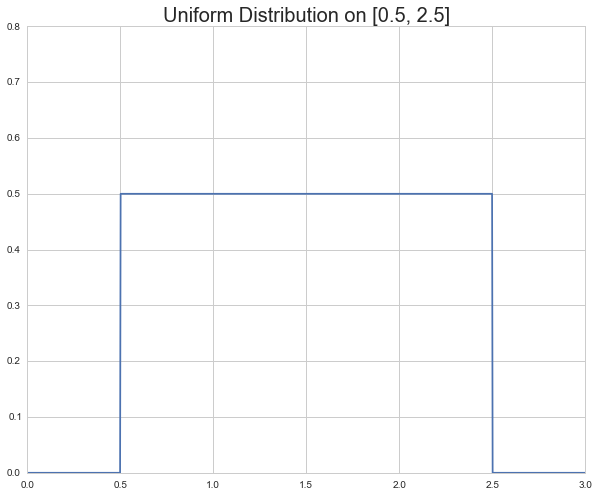

In [2]:
plt.figure(figsize = (10,8))
x = np.linspace(0, 3, 1000)
a = 0.5
b = 2.5
l = b - a
plt.title('Uniform Distribution on [0.5, 2.5]', fontsize = 20)
plt.plot(x, stats.uniform.pdf(x, a, l))
plt.xlim([0, 3])
plt.ylim([0, 0.8])

### Binomial distribution

The data generating process that describes number of heads in a series of random coin flips.  

(400, 600)

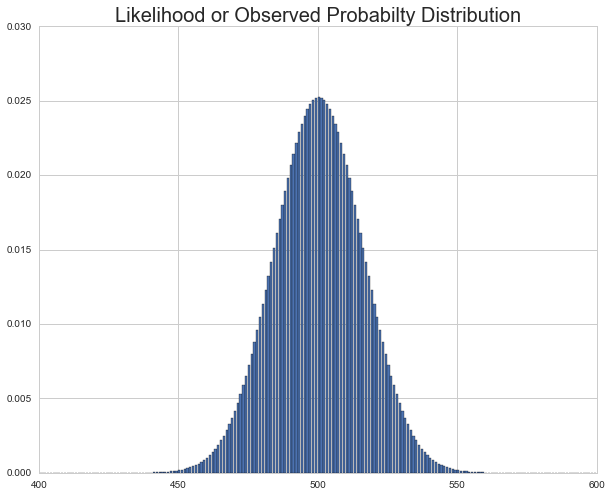

In [3]:
# Flip a fair (or balanced) coin a large number of times

plt.figure(figsize = (10,8))
r = range(1, 1000)
plt.title('Likelihood or Observed Probabilty Distribution', fontsize = 20)
plt.bar(r, stats.binom.pmf(r, p=0.5, n=1000))
plt.xlim([400, 600])

# Example 1: Is a Coin Balanced?

## Frequentist Approach

1. State a null hypothesis that the coin is balanced. $H_0$: Pr(heads) = 0.5. 
2. Establish a rejection region for the null hypothesis (or a $\big\vert$ t-stat $\big\vert$ in excess of 1.96).
3. Obtain data by flipping a coin 10 times.
4. Calculate the sample proportion as the (number of heads)/10.
5. If the outcome were 6 heads, a data scientist would fail to reject the null because the t-stat would be small.  

This approach does not allow for a data scientist to express her prior beliefs regarding the nature of coin, in particular whether she believes it is balanced.  Moreover, once she make a decision about whether to reject or fail to reject $H_0$, what could she do with additional data?  

## Bayesian Approach

1. Express your prior beliefs ("priors") in terms of a probability distribution function about the coin itself.  In this example, such priors may be a uniform probability distribution function ("vague" or "uninformed" priors).  Alternatively, your beliefs may be that the coin is not balanced because tails is more likely than heads or heads is more likely than tails because you have prior information.  Alternatively, you may express a high degree of belief that the coin is balanced (again expressed a probability distribution function).
2. Obtain data by flipping a coin 10 times.  (Recall that we can express the DGP of coin flipping as a binomial distribution, which we call the likelihood.)
3. Based on the observed outcomes, generate a posterior probability distribution function about the nature of the coin by combining your priors with the likelihood.  Because we have a probability distribution function, we can calculate many different things, such as an average, a standard deviation, and whether Pr(heads) $\ge$ 0.5.

Let's do this in R.  

(NB: This example works well because of the so-called "conjugate prior".  I don't want to dwell on this.  I want you to see a visualization that is aimed show you how a prior interacts with experimental data to affect a posterior.  We break away from the need of conjugacy through the use of MCMC simulation.)

# R Visualization

# A Criticism and The Response

The standard criticism of the Bayesian approach to inference is that a data scientist's prior beliefs are subjective.  

This is true.  But the prior beliefs are openly and explicitly stated in probabilistic terms.  In other words, the priors are an overt and clear statement regarding model assumptions.  Moreover, the use of prior beliefs is a systematic way to incorporate prior "domain knowledge" on a subject (that is, expertise).  Finally, it can be shown that the formulation of the posterior probability distribution function is dominated by the observed data, not by the the data scietist's prior beliefs or expertise.

Unlike the frequestist approach, the Bayesian approach provides a rigorous way to make probability statements about the real quantities of interest for a data scientist.  It does not view these real quantities as fixed in repeated samples, an assumption that lies at the heart of frequentist approach.  The Bayesian approach also permits the ability to update these probability statements as new infromation is received.  This is a form of learning.  

Finally, as noted in the New York Times article, the Bayesian approach is proving successful when applied in a variety of different contexts.  (And its use in data science is growing considerably with computational power and open-source statistical computing.)

# What Do Bayesians Need for Inference?

The formal estimation of a Bayesian model is the most difficult undertaking in Bayesian analysis.  The simple coin flipping example was instructive, but it relies on conjugacy, which is a limitation.  

The modern Bayesian approach is to summarize the $entire$ posterior probability distribution, which is necessary to make probabilistic statements about real quantities of interest for data scientists.  (The Bayes calculation in the video example produces a single value.  In truth, modern Bayesian inference relies on a probability distribution.)  

This undertaking is achieved through Markov Chain Monte Carlo (MCMC) simulation, and I will now show two popular MCMC algorithms using the bivariate normal distribution.

# MCMC Simulation I: the Gibbs algorithm 

Recall that we have looked at the bivariate normal distribution.  It was used to generate the first scatterplot for this class.  We are going to use this distribution to implement the Gibbs MCMC algorithm.  

We will see even if we have a starting value for our MCMC process that is far away from the distribution that we are simulating, we are able to converge rapidly through a process called "burn in".  Once our MCMC sequence has burned in, it will sample the distribution in a manner that is proportional to the distribution being simulated.  

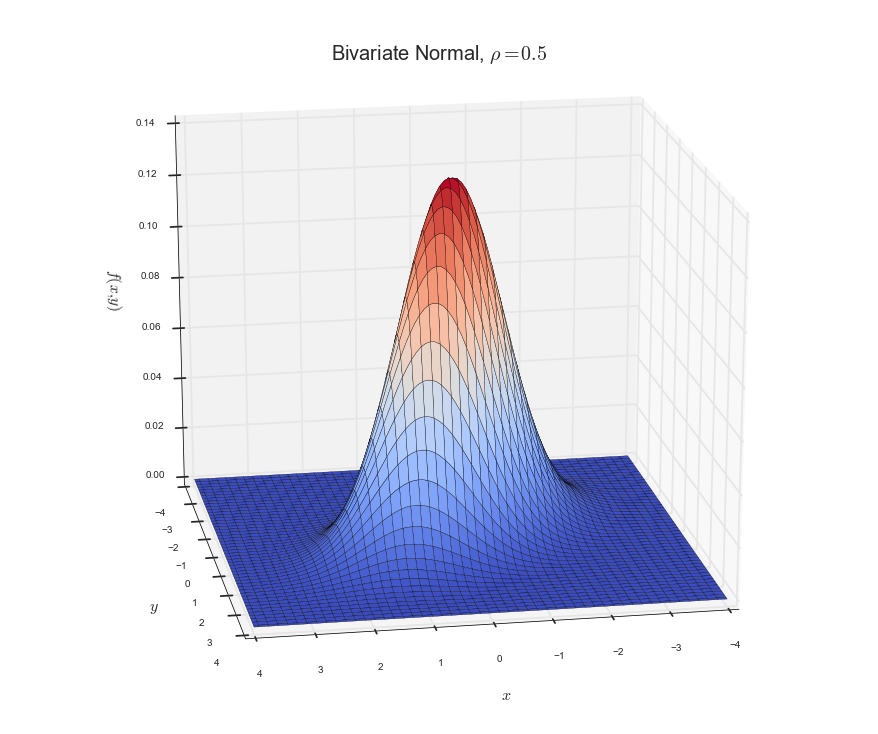

In [4]:
# Recall the 3D image for the bivariate normal.  Keep this image in your mind.  
# The bluer the region, the less likely is it.  The redder the region, the more likely it is.

import matplotlib.cm as cm

x, y = np.linspace(-4, 4, 100), np.linspace(-4, 4, 100)
x, y = np.meshgrid(x, y)
z = np.mat(np.zeros(2))
p = np.zeros(np.shape(x))
R = np.matrix([[1, 0.5],[0.5, 1]])
Rinv = linalg.inv(R)

for i in range(len(x)):
    for j in range(len(y)):
        z[0, 0] = x[i, j]
        z[0, 1] = y[i, j]
        p[i, j] = (1.0 / (2 * np.pi) * np.sqrt(linalg.det(R))) * np.exp(-(z * Rinv *z.T) / 2)

fig = plt.figure(figsize = (12, 10))
ax = Axes3D(fig)
#ax.plot_wireframe(x, y, p, rstride=3, cstride=3, color='#AD5300')
ax.plot_surface(x, y, p, rstride=2, cstride=2, cmap=cm.coolwarm, shade='interp')
#ax.plot_wireframe(x, y, p, rstride=3, cstride=3, color='black')
ax.view_init(20, 80) # rotation through 20, 40, 60, 80
ax.set_xlabel(r'$x$', fontsize = 16)
ax.set_ylabel(r'$y$', fontsize = 16)
ax.set_zlabel(r'$f(x, y)$', fontsize = 16)
ax.set_title(r'Bivariate Normal, $\rho = 0.5$', fontsize = 20)

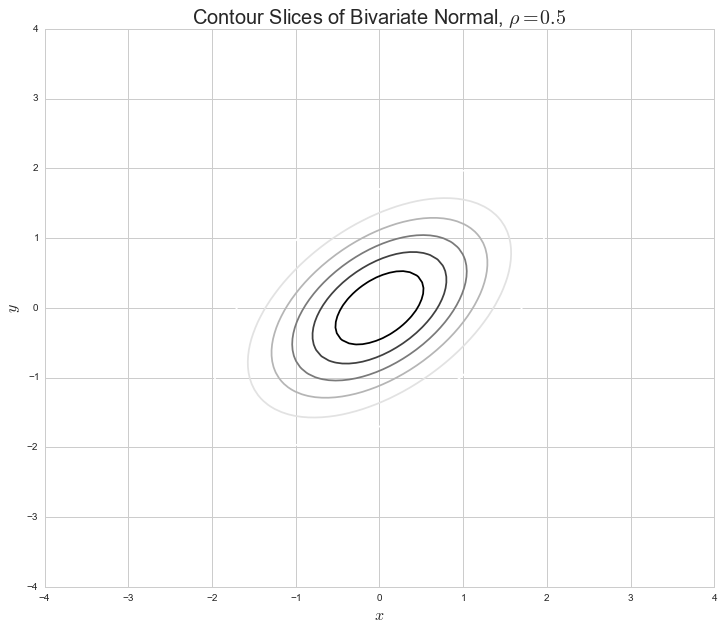

In [5]:
# Contour slices show what we will are simulating.
# The darker the ring, the more likely it the area within it.

fig = plt.figure(figsize = (12, 10))
ax = fig.gca()
ax.contour(x, y, p)  
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
ax.set_xlabel(r'$x$', fontsize = 16)
ax.set_ylabel(r'$y$', fontsize = 16)
ax.set_title(r'Contour Slices of Bivariate Normal, $\rho = 0.5$', fontsize = 20)

In [6]:
# This is Gibbs algorithm to simulate the contour slices of a 
# bivariate normal with rho = 0.5.
# Start the MCMC chain at an arbitrary starting value (-10, -10).
# Our results are not dependent on this artibrary starting value.

# mc is the number of mcmc replications.
# start is the starting point, (start, start).
mc = 10000 
start = -10

x = np.zeros(mc)
y = np.zeros(mc)  
x[0], y[0] = start, start

for i in range(2, mc): 
    x[i] = np.random.normal(loc = 0.5 * y[i-1], scale = np.sqrt(1 - 0.5 * 0.5), size=1) 
    y[i] = np.random.normal(loc = 0.5 * x[i], scale = np.sqrt(1- 0.5 * 0.5), size=1)

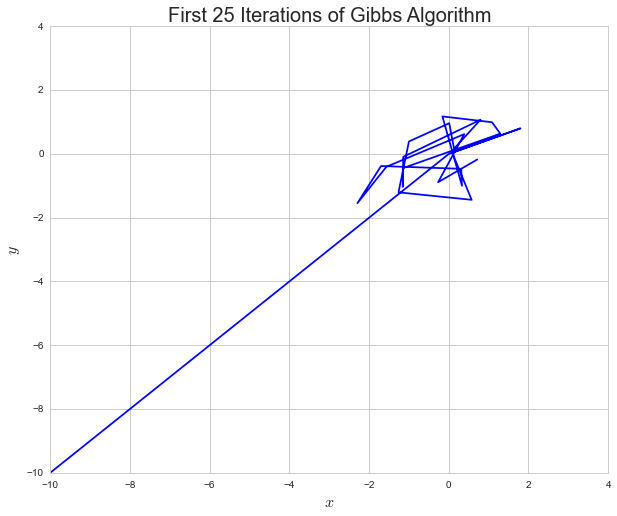

In [7]:
# We start the MCMC chain at an arbitrary point and follow its progression
# by connecting all the simulated points with a line.
# We want to see the simulated point "build up" throughout the support
# of the bivariate normal.

plt.figure(figsize = (10,8))
plt.plot(x[0:24], y[0:24], 'b')
plt.xlim(-10,4)
plt.ylim(-10,4)
plt.xlabel(r'$x$', fontsize = 16)
plt.ylabel(r'$y$', fontsize = 16)
plt.title(r'First 25 Iterations of Gibbs Algorithm', fontsize = 20)

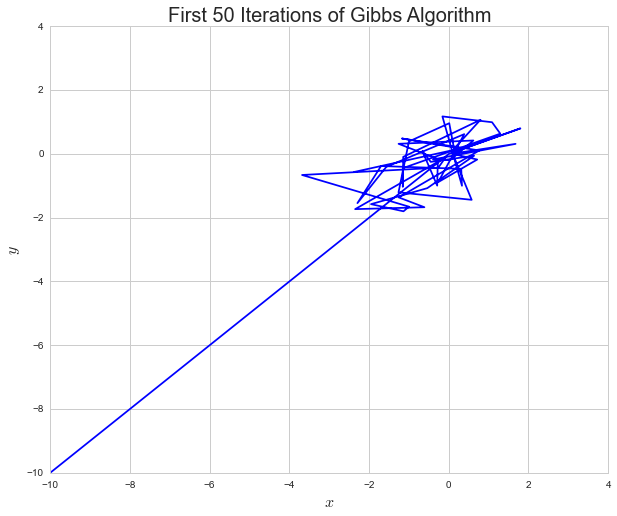

In [8]:
plt.figure(figsize = (10,8))
plt.plot(x[0:49], y[0:49], 'b')
plt.xlim(-10,4)
plt.ylim(-10,4)
plt.xlabel(r'$x$', fontsize = 16)
plt.ylabel(r'$y$', fontsize = 16)
plt.title(r'First 50 Iterations of Gibbs Algorithm', fontsize = 20)

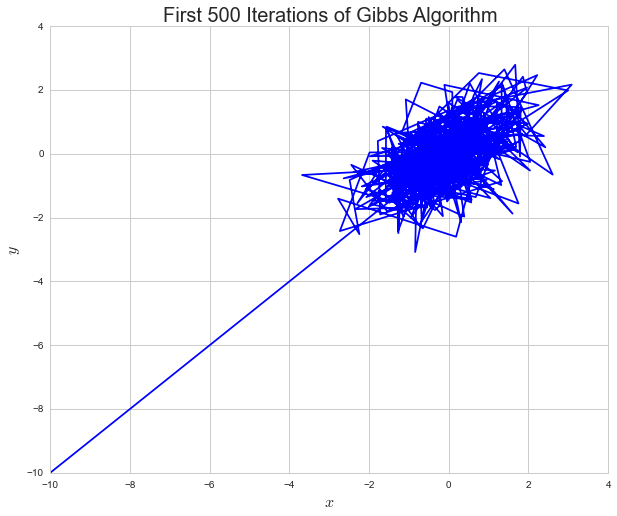

In [9]:
plt.figure(figsize = (10,8))
plt.plot(x[0:499], y[0:499], 'b')
plt.xlim(-10,4)
plt.ylim(-10,4)
plt.xlabel(r'$x$', fontsize = 16)
plt.ylabel(r'$y$', fontsize = 16)
plt.title(r'First 500 Iterations of Gibbs Algorithm', fontsize = 20)

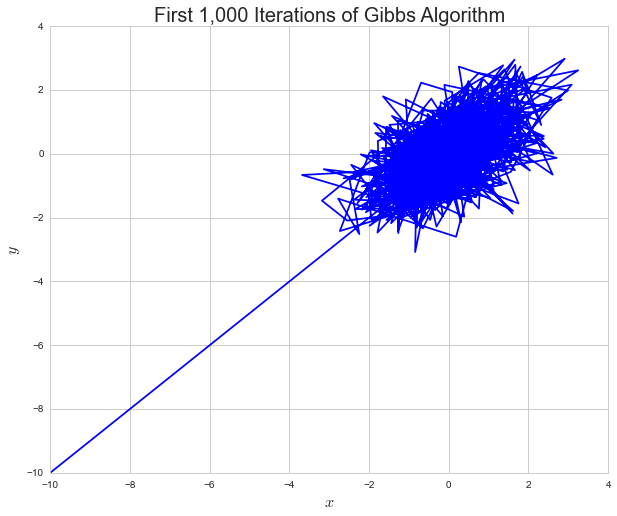

In [10]:
plt.figure(figsize = (10,8))
plt.plot(x[0:999], y[0:999], 'b')
plt.xlim(-10,4)
plt.ylim(-10,4)
plt.xlabel(r'$x$', fontsize = 16)
plt.ylabel(r'$y$', fontsize = 16)
plt.title(r'First 1,000 Iterations of Gibbs Algorithm', fontsize = 20)

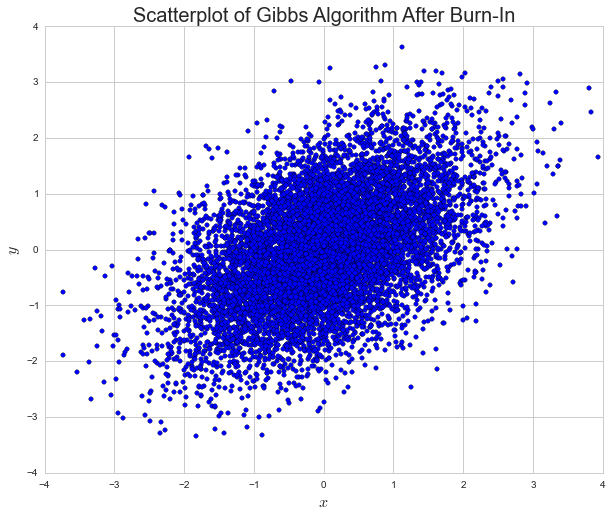

In [11]:
# Treat the first 500 MCMC replications as the burn in and discard them.
# Generate a scatterplot of the remaining replications.
# Get rid of the lines connecting the MCMC replications.
# Notice what is important in these MCMC replications (keeping in mind 
# the bivariate normal): their coverage is heavy where the bivariate normal
# is most probable, and it is thin where the bivariate normal is the least
# probable.

# This is the the key to simulating a distribution function using MCMC.

plt.figure(figsize = (10,8))
plt.scatter(x[499:9999], y[499:9999], c='b')
plt.xlim(-4, 4)
plt.ylim(-4 ,4)
plt.xlabel(r'$x$', fontsize = 16)
plt.ylabel(r'$y$', fontsize = 16)
plt.title(r'Scatterplot of Gibbs Algorithm After Burn-In', fontsize = 20)

0.0104978482671 [-1.92628086  1.99909576]


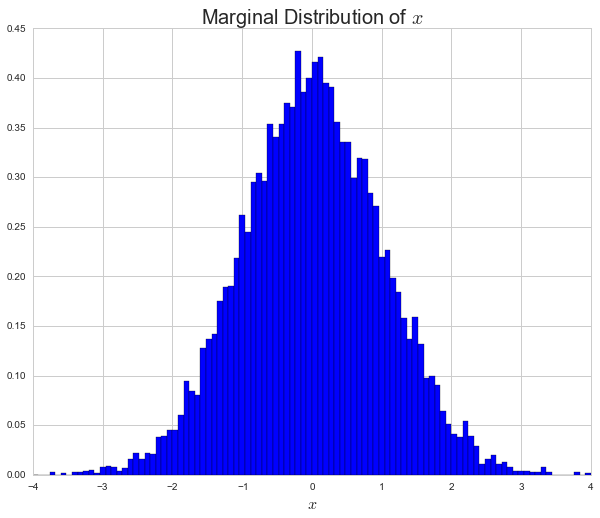

In [12]:
# Having simulated the bivariate normal with the Gibbs algorithm, we can
# examine to key aspects of the bivariate normal, namely the marginal
# distributions of x and y.  
# Recall in this context what the marginal of x is, and what the marginal of y is.
# The marginals are simply univariate normals with mean 0 and variance 1.

# Calculate the average posterior together with 95% credible interval.
# We have basically recreated the univariate normal.
# Note the 2.5th and 97.5th percentiles.

plt.figure(figsize = (10,8))
plt.hist(x[499:9999], bins=100, range=(-4, 4), normed=True, color='b')
plt.xlabel(r'$x$', fontsize = 16)
plt.title(r'Marginal Distribution of $x$', fontsize = 20)

print (x[499:9999].mean(), np.percentile(x[499:9999], (2.5, 97.5)))

0.00748122850558 [-1.9590085   1.97474279]


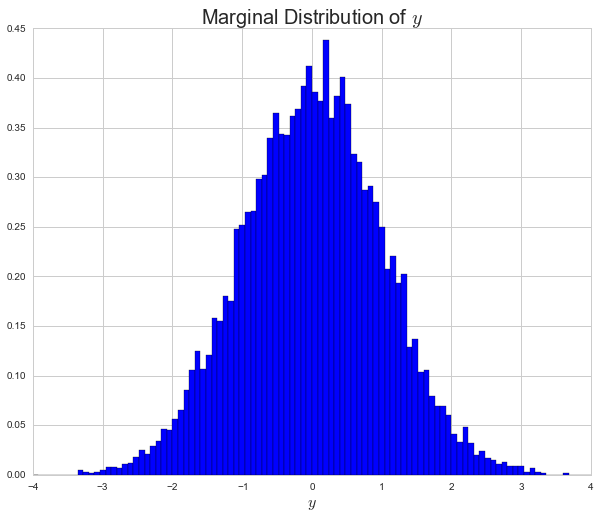

In [13]:
# Do the same for marginal of y, which recreates the univariate normal.
# See average posteriori and 95% credible interval.

plt.figure(figsize = (10,8))
plt.hist(y[499:9999], bins=100, range=(-4, 4), normed=True, color='b')
plt.xlabel(r'$y$', fontsize = 16)
plt.title(r'Marginal Distribution of $y$', fontsize = 20)

print (y[499:9999].mean(), np.percentile(y[499:9999], (2.5, 97.5)))

# MCMC Simulation II: the Metropolis Hastings algorithm

One parameter of interest for the bivariate normal distribution is $\rho$, the correlation coefficient.  We are going to use the Metropolis-Hasting MCMC algorithm to simulate the posterior distribution of $\rho$ and to conduct Bayesian hypothesis testing.

In [14]:
# Sample from (log) posterior of rho using Metropolis Hastings algorithm.
# using the bivariate normal with mean zero, variance 1, and rho = 0.5

# ss is the sample size of the observed data
# draws is the number of MCMC draws
ss = 1000 
mean = [0,0] 
R = np.matrix([[1, 0.5],[0.5, 1]])

draws = 10000 
corr = np.zeros(draws) # Initialize vector containing draws
acctot = 0 # A counter for accepted MCMC draws
adj = (ss + 3.0) / 2.0 # Sample size adjustment in the log posterior of rho

x, y = np.random.multivariate_normal(mean, R, ss).T # Draw the observed data

# Commence MH algorithm at 0
for i in range(1, draws):
    acc = 1 # Assume acceptible draw
    corr[i] = corr[i - 1] + np.random.uniform(-.07, .07, 1) # Add symmetric random variable 
    
    if abs(corr[i]) > 1: 
        corr[i] = corr[i-1] # Don't change 
    
    # Evaluation of current and prior draw
    a = -adj * np.log(1 - corr[i] ** 2) - 0.5 * (np.sum(x ** 2) - 2.0 * corr[i] * np.sum(x * y) 
                                                 + np.sum(y ** 2)) / (1 - corr[i] ** 2)
    b = -adj * np.log(1 - corr[i-1] ** 2) - 0.5 * (np.sum(x ** 2) - 2.0 * corr[i-1] * np.sum(x * y) 
                                                   + np.sum(y ** 2)) / (1 - corr[i-1] ** 2)
                
    if (a - b) < np.log(np.random.uniform(0, 1, 1)): # Metropolis Hastings criterion for rejection
        acc = 0 # Reject
        corr[i] = corr[i-1] # Don't change
        
    acctot += acc

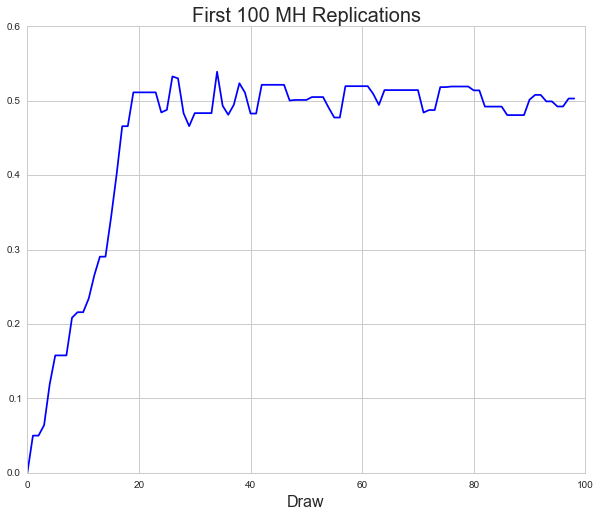

In [15]:
# Plot the first 50 MCMC Replications starting at rho = 0.
# Again we want to see the algorithm burn in, converging to a value around
# rho = 0.5 and stay in that region.

plt.figure(figsize=(10, 8))
plt.plot(corr[0:99], c='b')
plt.title('First 100 MH Replications', fontsize = 20)
plt.xlabel('Draw', fontsize = 16)

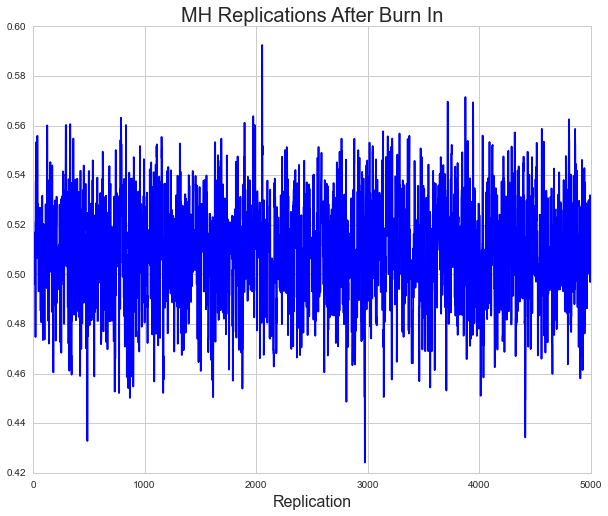

In [16]:
# Plot MH replications after a burn in of 5,000.
# Note the stability of the replications.

plt.figure(figsize=(10, 8))
plt.plot(corr[4999:9999], c='b')
plt.title('MH Replications After Burn In', fontsize = 20)
plt.xlabel('Replication', fontsize = 16)

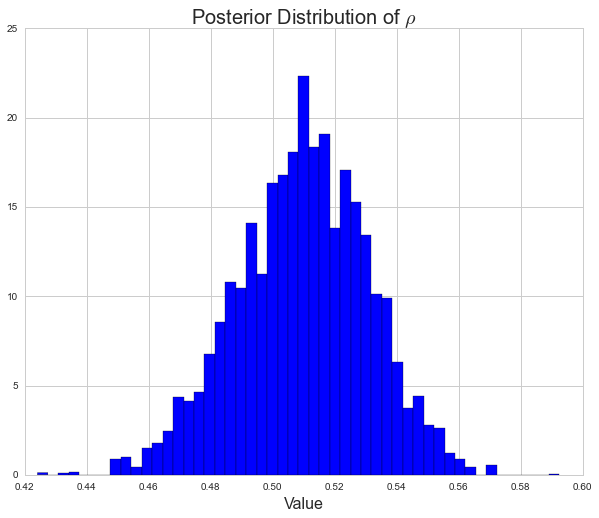

In [17]:
# We have simulated the posterior distribution function of rho.
# Plot it.

plt.figure(figsize=(10, 8))
plt.hist(corr[4999:9999], bins=50, normed=True, color='b')
plt.title(r'Posterior Distribution of $\rho$', fontsize = 20)
plt.xlabel('Value', fontsize = 16)

In [18]:
# This is the observed correlation in the data, which a frequentist would 
# view as a fixed value.

print (np.corrcoef(x, y)[1, 0])

0.508747561203


In [19]:
# A Bayesian would focus on the posterior distribution function simulated
# using MCMC algorithm, from which key metrics can be calculated.
# Average of the posterior after burn-in.

print (corr[4999:9999].mean())

0.509662612878


In [20]:
# This is standard deviation of the posterior after burn-in

print (corr[4999:9999].std())

0.0212490211623


In [21]:
# This is the 95% Bayesian credible internal after burn-in

print (np.percentile(corr[4999:9999], (2.5, 97.5)))

[ 0.46679108  0.54976536]


In [22]:
# Bayesian hypothesis test that rho exceeds 0.5
# Testing such a hypothesis for a frequentist is very difficult.  
# Here it is simple.

print (np.mean(corr[4999:9999]>0.5))

0.6886


# Example 2: Simulating the posterior probabilty distributions of $\alpha$ and $\beta$ from the CAPM.

In [2]:
# Read in AAPL and NASDAQ and generate returns.

aapl_all = Quandl.get("YAHOO/AAPL", trim_start="2010-1-1", trim_end="2015-09-18")
nasdaq_all = Quandl.get("NASDAQOMX/COMP", trim_start="2010-1-1", trim_end="2015-09-18")
aapl = aapl_all['Adjusted Close']
nasdaq = nasdaq_all['Index Value']
aapl_returns = np.log(aapl / aapl.shift(1))
nasdaq_returns = np.log(nasdaq / nasdaq.shift(1))
aapl_returns = aapl_returns.dropna()
nasdaq_returns = nasdaq_returns.dropna()

In [3]:
# Start with frequentist approach.
# Conduct hypothesis testing.

aapl_r = pd.DataFrame(aapl_returns)
nasdaq_r = pd.DataFrame(nasdaq_returns)
data = pd.merge(nasdaq_r, aapl_r, left_index=True, right_index=True)
data.rename(columns={'Index Value':'nasdaq', 'Adjusted Close':'aapl'}, inplace=True)
mod = smf.ols(formula='aapl ~ nasdaq', data = data).fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:                   aapl   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                     955.2
Date:                Wed, 14 Oct 2015   Prob (F-statistic):          3.49e-161
Time:                        20:52:40   Log-Likelihood:                 4194.7
No. Observations:                1437   AIC:                            -8385.
Df Residuals:                    1435   BIC:                            -8375.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.0005      0.000      1.362      0.1

In [4]:
# Turn to the Bayesian approach where we will simulate 
# the posterior probability distributions of alpha and beta from CAPM.  
# Sigma is the variance, which we can ignore.
# We will show how hypothesis testing using a Bayesian approach is 
# straightforward and could be the basis of decision making.

# This is the syntax for PyMC3, 
# the Python library that allows one to do canned Bayesian estimation.
# See https://pymc-devs.github.io/pymc3/getting_started/.
# If you were to use this with different returns data,
# just replace 'nasdaq_returns' with the returns to the market
# and 'aapl_returns' with the returns to the particular stock

with pm.Model() as model:
    # alpha, beta, and sigma are the hyperparameters over which we have our priors, in this case they are flat priors.    
    alpha = pm.Normal('alpha', mu=0, sd=20)
    beta = pm.Normal('beta', mu=0, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    
    # y_est is the specification of the Bayesian model to be estimated.  It is simply our CAPM.
    y_est = alpha + beta * nasdaq_returns
    
    # likelihood is the likelihood function, here it is normal to be used with conjugate priors.    
    likelihood = pm.Normal('y', mu=y_est, sd=sigma, observed=aapl_returns)
    
    # We use the Maximum a Posteriori (MAP) values as starting values for the MCMC sampling.
    start = pm.find_MAP()
    step = pm.NUTS(state=start)
    trace = pm.sample(1000, step, start=start, progressbar=True)

 [-----------------100%-----------------] 1000 of 1000 complete in 5.9 sec

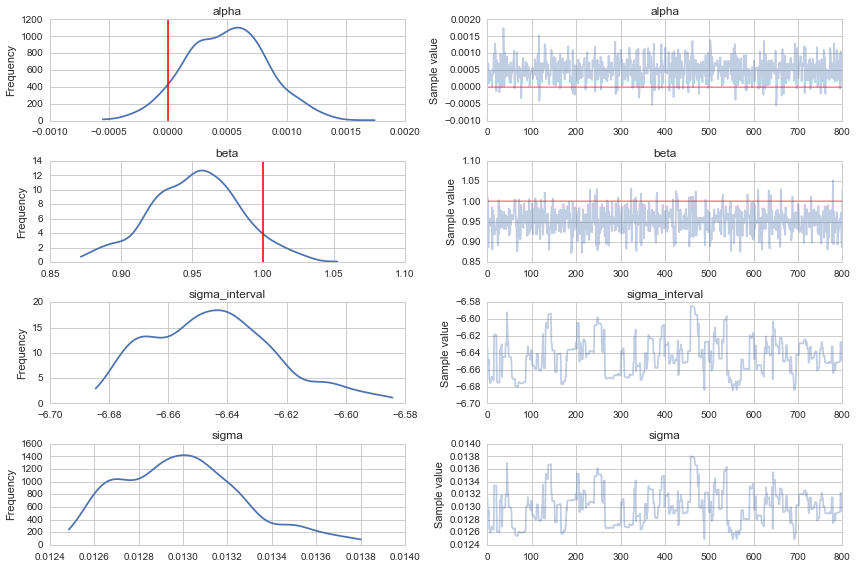

In [5]:
# Show results after burn in of 200 MCMC replications.

fig = pm.traceplot(trace[199:1000], lines={'alpha': 0, 'beta': 1})
plt.figure(figsize = (12, 10))

This is the strength of the Bayesian approach.  Using transparent prior beliefs, combined with real-world data, we have simulated the posterior distribution functions of two quantities of interest to a data scientist.  (You can ignore 
sigma stuff.)

In [27]:
# Having simulated the entire posterior probability distributions, 
# we can calculate useful metrics.

# Start with averages and 95% credible intervals.
# Note their simularity to the least squares results.

print ("Average alpha and its 95% credible interval are:", np.mean(trace['alpha'][199:1000]), np.percentile(trace['alpha'][199:1000], (2.5, 97.5)))
print ("Average beta and its 95% credible interval are:", np.mean(trace['beta'][199:1000]), np.percentile(trace['beta'][199:1000], (2.5, 97.5)))
print ()
print (mod.summary())

Average alpha and its 95% credible interval are: 0.000467383279587 [-0.00022822  0.00113473]
Average beta and its 95% credible interval are: 0.953726950031 [ 0.891191    1.01583309]

                            OLS Regression Results                            
Dep. Variable:                   aapl   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                     955.2
Date:                Sat, 10 Oct 2015   Prob (F-statistic):          3.49e-161
Time:                        00:13:42   Log-Likelihood:                 4194.7
No. Observations:                1437   AIC:                            -8385.
Df Residuals:                    1435   BIC:                            -8375.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    st

In [28]:
# Test two valuable hypotheses.
# alpha > 0
# beta < 1
# These are key inputs to decision making.

print ("The probability that alpha is greater than zero is", np.mean(trace['alpha'][199:1000] > 0.0))
print ("The probability that beta is less than one is", np.mean(trace['beta'][199:1000] < 1.0))

The probability that alpha is greater than zero is 0.910112359551
The probability that beta is less than one is 0.932584269663


In [29]:
# Do another CAPM with Yahoo!

yhoo_all = Quandl.get("YAHOO/YHOO", trim_start="2010-1-1", trim_end="2015-09-18").dropna()
nasdaq_all = Quandl.get("NASDAQOMX/COMP", trim_start="2010-1-1", trim_end="2015-09-18")
yhoo = yhoo_all['Adjusted Close']
nasdaq = nasdaq_all['Index Value']
yhoo_returns = np.log(yhoo / yhoo.shift(1))
nasdaq_returns = np.log(nasdaq / nasdaq.shift(1))
yhoo_returns = yhoo_returns.dropna()
nasdaq_returns = nasdaq_returns.dropna()

In [30]:
with pm.Model() as model:
    # alpha, beta, and sigma are the hyperparameters over which we have our priors, in this case they are flat priors.    
    alpha = pm.Normal('alpha', mu=0, sd=20)
    beta = pm.Normal('beta', mu=0, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    
    # y_est is the specification of the Bayesian model to be estimated.  It is simply our CAPM.
    y_est = alpha + beta * nasdaq_returns
    
    # likelihood is the likelihood function, here it is normal to be used with conjugate priors.    
    likelihood = pm.Normal('y', mu=y_est, sd=sigma, observed=yhoo_returns)
    
    # We use the Maximum a Posteriori (MAP) values as starting values for the MCMC sampling.
    start = pm.find_MAP()
    step = pm.NUTS(state=start)
    trace = pm.sample(1000, step, start=start, progressbar=True)

 [-----------------100%-----------------] 1001 of 1000 complete in 8795.7 sec

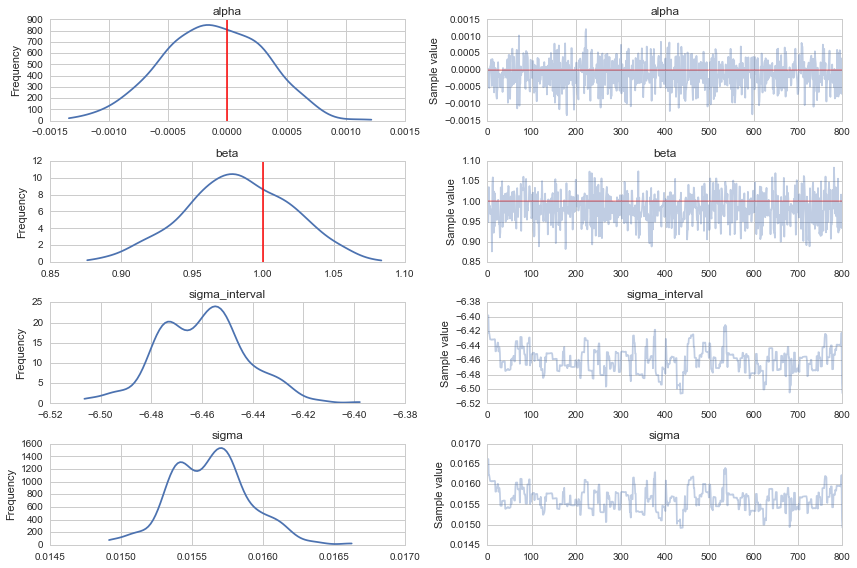

In [31]:
fig = pm.traceplot(trace[199:1000], lines={'alpha': 0, 'beta': 1})
plt.figure(figsize = (12, 10))

In [32]:
# Having simulated the entire posterior probability distributions, 
# we can calculate useful metrics.

# Start with averages and 95% credible intervals.

print ("Average alpha and its 95% credible interval are:", np.mean(trace['alpha'][199:1000]), np.percentile(trace['alpha'][199:1000], (2.5, 97.5)))
print ("Average beta and its 95% credible interval are:", np.mean(trace['beta'][199:1000]), np.percentile(trace['beta'][199:1000], (2.5, 97.5)))
print ()

# Test two valuable hypotheses.
# alpha > 0
# beta < 1
# These are key inputs to decision making.

print ("The probability that alpha is greater than zero is", np.mean(trace['alpha'][199:1000] > 0.0))
print ("The probability that beta is less than one is", np.mean(trace['beta'][199:1000] < 1.0))

Average alpha and its 95% credible interval are: -0.000120561761704 [-0.00096515  0.00064988]
Average beta and its 95% credible interval are: 0.982433995177 [ 0.90910603  1.05539717]

The probability that alpha is greater than zero is 0.40074906367
The probability that beta is less than one is 0.674157303371


In [40]:
# Now with Griliches.

griliches = pd.read_csv("griliches.csv")

lw = griliches['lw']
s = griliches['s']

In [42]:
with pm.Model() as model:
    # alpha, beta, and sigma are the hyperparameters over which we have our priors, in this case they are flat priors.    
    constant = pm.Normal('constant', mu=0, sd=20)
    education = pm.Normal('education', mu=0, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    
    # y_est is the specification of the Bayesian model to be estimated.  It is simply our CAPM.
    y_est = constant + education * s
    
    # likelihood is the likelihood function, here it is normal to be used with conjugate priors.    
    likelihood = pm.Normal('y', mu=y_est, sd=sigma, observed=lw)
    
    # We use the Maximum a Posteriori (MAP) values as starting values for the MCMC sampling.
    start = pm.find_MAP()
    step = pm.NUTS(state=start)
    trace = pm.sample(1000, step, start=start, progressbar=True)

 [-----------------100%-----------------] 1001 of 1000 complete in 5649.4 sec

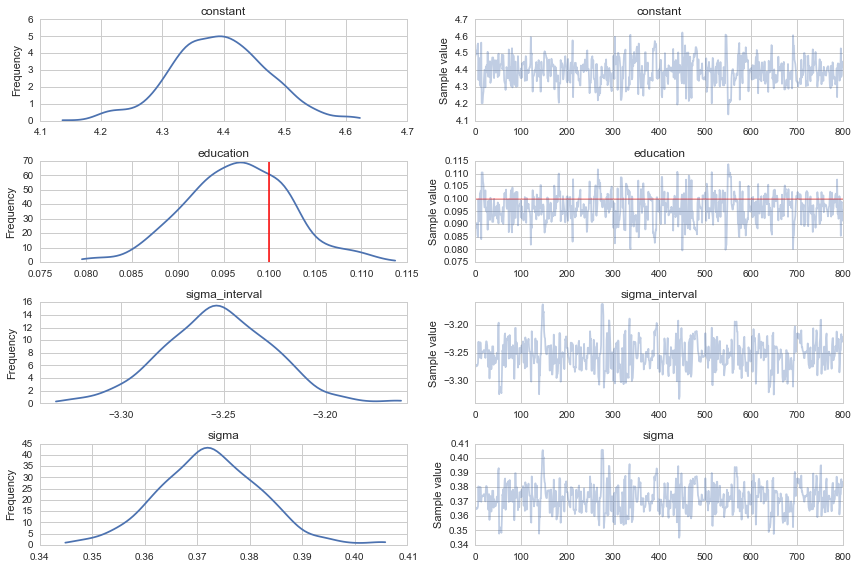

In [43]:
fig = pm.traceplot(trace[199:1000], lines={'education': 0.1})
plt.figure(figsize = (12, 10))

In [47]:
# Having simulated the entire posterior probability distributions, 
# we can calculate useful metrics.

# Start with averages and 95% credible intervals.

print ("Average returns to schooling and their 95% credible interval are:", np.mean(trace['education'][199:1000]), np.percentile(trace['education'][199:1000], (2.5, 97.5)))
print ()

# Test two valuable hypotheses.
# alpha > 0
# beta < 1
# These are key inputs to decision making.

print ("The probability that returns to schooling are greater than 10% are", np.mean(trace['education'][199:1000] > 0.1))

Average returns to schooling and their 95% credible interval are: 0.096525008727 [ 0.08555374  0.1085375 ]

The probability that returns to schooling are greater than 10% are 0.278401997503
